# Dataset Foundation & Structure Analysis

## 1. Setup and Imports

In [1]:
# Standard library
import os
from typing import Any
import sys

# Third-party libraries
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Plot styles
plt.rcdefaults()
plt.style.use("seaborn-v0_8-colorblind")
sns.set_palette("colorblind")

# Version info
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Dask version: {dask.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Python version: 3.12.11 (main, Jun  3 2025, 15:41:47) [Clang 17.0.0 (clang-1700.0.13.3)]
NumPy version: 2.3.2
Pandas version: 2.3.2
Dask version: 2025.7.0
Matplotlib version: 3.10.5
Seaborn version: 0.13.2


## 2. Data Loading

Load the dataset using Dask.

In [2]:
def load_dataset(file_path: str) -> dd.DataFrame:
    print(f"Loading the dataset...")

    # Load dataset using dask
    df = dd.read_parquet(file_path, engine="pyarrow", dtype_backend="pyarrow")

    return df

df = load_dataset("../eda/food.parquet")

Loading the dataset...


Based on our EDA findings, the ingredients column is very large; therefore, we will drop it in this full data analysis.

In [3]:
df = df.drop(columns="ingredients")

Print the dataset shape.

In [4]:
df_shape = df.shape[0].compute(), df.shape[1]
print(f"Dataset shape: {df_shape}")
print(f"Total cells: {df_shape[0] * df_shape[1]:,}")

Dataset shape: (3919113, 109)
Total cells: 427,183,317


## 3. Column Structure Analysis

Run column structure analysis over the full dataset.

In [5]:
def analyse_column_structure(df: dd.DataFrame) -> pd.DataFrame:
    print(f"Analysing column structure...\n")

    column_analysis = []

    for col in df.columns:
        print(f"Analysing column: {col}")

        col_data = df[col]

        null_count_expr = col_data.isna().sum()
        sample_df_expr = col_data.map_partitions(lambda s: s.dropna().head(1))

        with ProgressBar():
            null_count, sample_df = dask.compute(
                null_count_expr,
                sample_df_expr,
            )

        sample_value = sample_df.iloc[0] if not sample_df.empty else None

        analysis = {
            "column_name": col,
            "data_type": str(col_data.dtype),
            "missing_percentage": null_count / df_shape[0] * 100,
            "sample": sample_value,
        }

        column_analysis.append(analysis)

    return pd.DataFrame(column_analysis)

column_analysis_df = analyse_column_structure(df)

Analysing column structure...

Analysing column: additives_n
[########################################] | 100% Completed | 6.04 ss
Analysing column: additives_tags
[########################################] | 100% Completed | 6.09 ss
Analysing column: allergens_tags
[########################################] | 100% Completed | 5.92 ss
Analysing column: brands_tags
[########################################] | 100% Completed | 6.03 ss
Analysing column: brands
[########################################] | 100% Completed | 6.04 ss
Analysing column: categories
[########################################] | 100% Completed | 6.04 ss
Analysing column: categories_tags
[########################################] | 100% Completed | 5.69 ss
Analysing column: categories_properties
[########################################] | 100% Completed | 5.56 ss
Analysing column: checkers_tags
[########################################] | 100% Completed | 5.84 ss
Analysing column: ciqual_food_name_tags
[############

A function to print a numbered column name with optional description and a truncated sample value.

In [6]:
def print_col(
    i: int,
    col: str,
    desc: str | None = None,
    sample: Any | None = None,
) -> None:
    suffix = f" | {desc}" if desc else ""
    print(f"{i:3d}. {col:40s}{suffix}", end="")
    if sample is not None:
        s = str(sample)
        truncated = f"{s[:80]}..." if len(s) > 80 else s
        print(f" | {truncated}")

Analyse columns with >90% missing data and columns without missing data.

In [7]:
print(f"Total columns: {column_analysis_df.shape[0]}")

print(f"\nColumns with >90% missing data:\n")
for i, row in enumerate(column_analysis_df[column_analysis_df["missing_percentage"] > 90].itertuples(index=False), start=1):
    print_col(i, row.column_name, desc=f"{row.missing_percentage:6.2f}% missing", sample=row.sample)

print(f"\nColumns with no missing data:\n")
for i, row in enumerate(column_analysis_df[column_analysis_df["missing_percentage"] == 0].itertuples(index=False), start=1):
    print_col(i, row.column_name, desc=f"{row.missing_percentage:6.2f}% missing", sample=row.sample)

Total columns: 109

Columns with >90% missing data:

  1. ecoscore_score                           |  95.07% missing | 80
  2. editors                                  |  98.51% missing | ['elttor', 'hangy', 'malikele', 'upcbot']
  3. new_additives_n                          |  99.99% missing | 2
  4. owner_fields                             |  97.62% missing | [{'field_name': 'data_sources', 'timestamp': 1709697630}, {'field_name': 'energy...
  5. owner                                    |  97.59% missing | org-label-non-gmo-project
  6. packagings_complete                      |  90.27% missing | True
  7. photographers                            |  99.89% missing | ['javichu']
  8. with_non_nutritive_sweeteners            |  99.19% missing | 1
  9. with_sweeteners                          |  99.84% missing | 1

Columns with no missing data:

  1. checkers_tags                            |   0.00% missing | []
  2. code                                     |   0.00% missing | 00001012

Analyse columns by different data types.

In [8]:
for dtype, group in column_analysis_df.groupby("data_type"):
    print(f"\nData type: \033[94m{dtype}\033[0m\n")
    for i, row in enumerate(group.itertuples(index=False), start=1):
        print_col(i, row.column_name, sample=row.sample)


Data type: bool[pyarrow]

  1. no_nutrition_data                        | False
  2. obsolete                                 | False
  3. packagings_complete                      | True

Data type: float[pyarrow]

  1. completeness                             | 0.6875

Data type: int32[pyarrow]

  1. additives_n                              | 0
  2. complete                                 | 0
  3. ecoscore_score                           | 80
  4. ingredients_from_palm_oil_n              | 0
  5. ingredients_n                            | 1
  6. ingredients_percent_analysis             | 1
  7. ingredients_with_specified_percent_n     | 0
  8. ingredients_with_unspecified_percent_n   | 1
  9. ingredients_without_ciqual_codes_n       | 1
 10. known_ingredients_n                      | 3
 11. max_imgid                                | 3
 12. new_additives_n                          | 2
 13. nova_group                               | 1
 14. nutriscore_score                         | 25

## 4. Column Categorisation

Categorise columns by domain/functionality.

In [9]:
nutritional_terms = [
    "carb", "energy", "fat", "fiber", "mineral", "nutri", "nucleotides",
    "protein", "quantity", "salt", "serving", "sodium", "sugar", "sweetener",
    "vitamin",
]
ingredients_terms = ["additives", "ingredient"]
allergens_terms = ["allergen", "traces"]
certifications_terms = ["labels"]
food_quality_terms = ["ecoscore", "nova"]
categories_terms = ["categor", "ciqual", "food_group"]
geographies_terms = ["cities", "countr", "origin", "place", "stores"]
packaging_terms = ["packag"]
data_quality_terms = [
    "checkers_tags", "correctors_tags", "data_quality", "informers_tags",
]
brands_terms = ["brand", "manufacturer"]
identifiers_terms = [
    "code", "generic_name", "images", "link", "max_imgid", "product_name",
]

def categorise_columns(row: pd.Series) -> str:
    col_lower = row["column_name"].lower()
    if any(term in col_lower for term in nutritional_terms):
        return "nutritional"
    elif any(term in col_lower for term in ingredients_terms):
        return "ingredients"
    elif any(term in col_lower for term in allergens_terms):
        return "allergens"
    elif any(term in col_lower for term in certifications_terms):
        return "certifications"
    elif any(term in col_lower for term in food_quality_terms):
        return "food_quality"
    elif any(term in col_lower for term in categories_terms):
        return "categories"
    elif any(term in col_lower for term in geographies_terms):
        return "geographies"
    elif any(term in col_lower for term in packaging_terms):
        return "packaging"
    elif any(term in col_lower for term in data_quality_terms):
        return "data_quality"
    elif any(term in col_lower for term in brands_terms):
        return "brands"
    elif any(term in col_lower for term in identifiers_terms):
        return "identifiers"
    else:
        return "metadata"

column_analysis_df["category"] = column_analysis_df.apply(categorise_columns, axis=1)

Analyse columns by functional categories.

In [10]:
for category, group in column_analysis_df.groupby("category"):
    print(f"\nCategory: \033[94m{category}\033[0m\n")
    for i, row in enumerate(group.itertuples(index=False), start=1):
        print_col(i, row.column_name, sample=row.sample)


Category: allergens

  1. allergens_tags                           | ['en:nuts']
  2. traces_tags                              | []

Category: brands

  1. brands_tags                              | ['xx:bovetti']
  2. brands                                   | Bovetti

Category: categories

  1. categories                               | Petit-déjeuners,Produits à tartiner,Produits à tartiner sucrés,Pâtes à tartiner,...
  2. categories_tags                          | ['en:breakfasts', 'en:spreads', 'en:sweet-spreads', 'fr:pates-a-tartiner', 'en:h...
  3. categories_properties                    | {'ciqual_food_code': 31032, 'agribalyse_food_code': 31032, 'agribalyse_proxy_foo...
  4. ciqual_food_name_tags                    | ['chocolate-spread-with-hazelnuts']
  5. compared_to_category                     | en:cocoa-and-hazelnuts-spreads
  6. food_groups_tags                         | ['en:sugary-snacks', 'en:sweets']

Category: certifications

  1. labels_tags                      

## 5. Data Completeness Analysis

Categorise column by missing severity.

In [11]:
def categorise_missing_severity(row: pd.Series) -> str:
    missing_percent = row["missing_percentage"]
    if missing_percent == 0:
        return "complete"
    elif missing_percent <= 10:
        return "minimal_missing"
    elif missing_percent <= 20:
        return "moderate_missing"
    elif missing_percent <= 50:
        return "high_missing"
    elif missing_percent <= 90:
        return "mostly_missing"
    else:
        return "extreme_missing"

column_analysis_df["missing_severity"] = column_analysis_df.apply(categorise_missing_severity, axis=1)

Analyse overall data completeness.

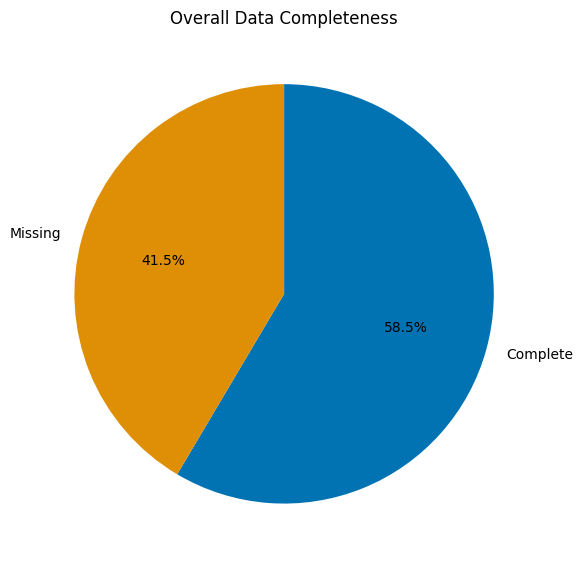

In [12]:
def plot_overall_data_completeness():
    total_missing_percent = column_analysis_df["missing_percentage"].mean()
    total_complete_percent = 100 - total_missing_percent

    labels = ["Complete", "Missing"]
    sizes = [total_complete_percent, total_missing_percent]

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.title("Overall Data Completeness")
    plt.tight_layout()
    plt.show()

plot_overall_data_completeness()

Analyse column completeness by missing severity.

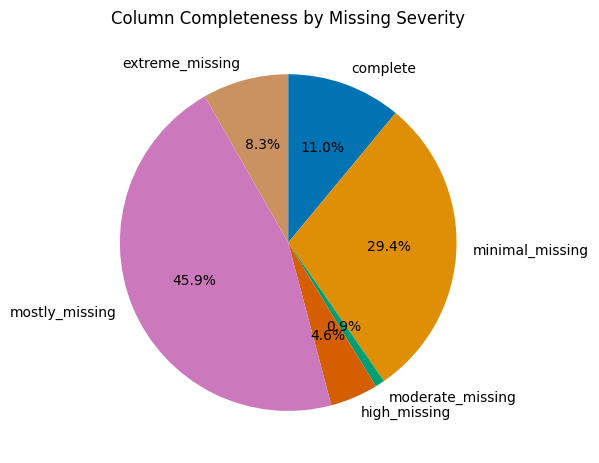

In [13]:
def plot_column_completeness_by_missing_severity():
    severity_counts = column_analysis_df["missing_severity"].value_counts()
    severity_percent = (severity_counts / severity_counts.sum()) * 100

    order = [
        "complete",
        "minimal_missing",
        "moderate_missing",
        "high_missing",
        "mostly_missing",
        "extreme_missing"
    ]

    severity_percent = severity_percent.reindex(order).fillna(0)

    plt.figure(figsize=(6, 6))
    plt.pie(severity_percent, labels=severity_percent.index, autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.title("Column Completeness by Missing Severity")
    plt.tight_layout()
    plt.show()

plot_column_completeness_by_missing_severity()

Analyse top 20 columns with most missing data.

In [14]:
def print_top_20():
    top20 = column_analysis_df.sort_values("missing_percentage", ascending=False).head(20)

    print(f"\nTop 20 columns with most missing data:\n")
    for i, row in enumerate(top20.itertuples(index=False), start=1):
        print_col(i, row.column_name, desc=f"{row.missing_percentage:.2f}% missing", sample=row.sample)

print_top_20()


Top 20 columns with most missing data:

  1. new_additives_n                          | 99.99% missing | 2
  2. photographers                            | 99.89% missing | ['javichu']
  3. with_sweeteners                          | 99.84% missing | 1
  4. with_non_nutritive_sweeteners            | 99.19% missing | 1
  5. editors                                  | 98.51% missing | ['elttor', 'hangy', 'malikele', 'upcbot']
  6. owner_fields                             | 97.62% missing | [{'field_name': 'data_sources', 'timestamp': 1709697630}, {'field_name': 'energy...
  7. owner                                    | 97.59% missing | org-label-non-gmo-project
  8. ecoscore_score                           | 95.07% missing | 80
  9. packagings_complete                      | 90.27% missing | True
 10. packaging                                | 81.49% missing | 
 11. packaging_tags                           | 81.48% missing | []
 12. link                                     | 79.19% missing

Analyse distribution of column completeness.

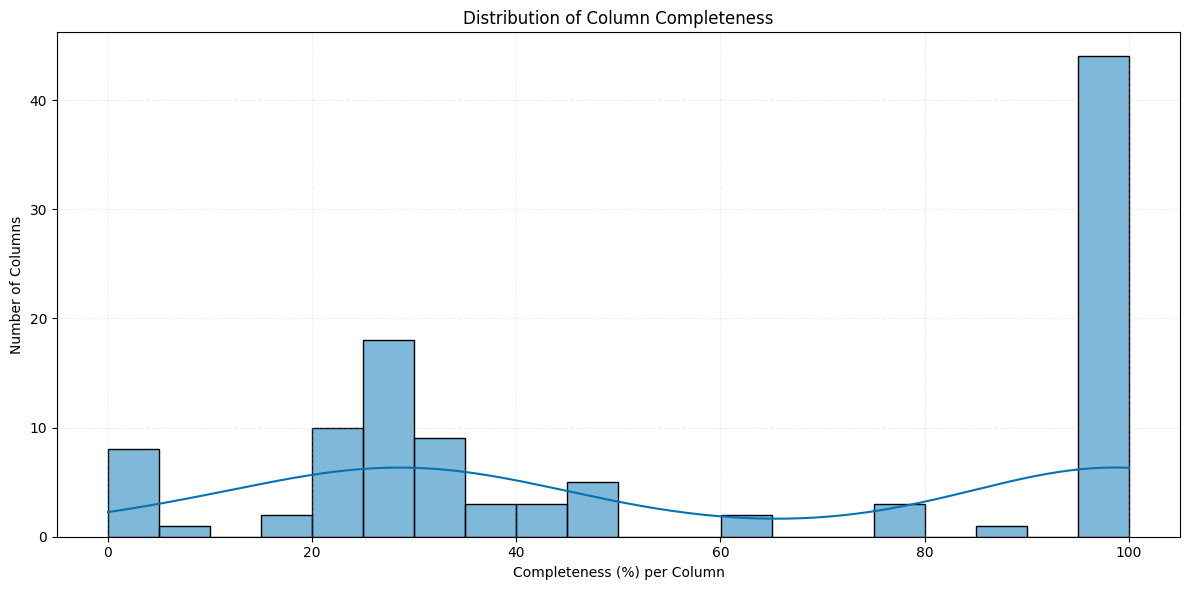

In [15]:
def plot_distribution_of_column_completeness():
    completeness = 100 - column_analysis_df["missing_percentage"]

    plt.figure(figsize=(12, 6))
    sns.histplot(completeness, bins=20, kde=True)
    plt.title("Distribution of Column Completeness")
    plt.xlabel("Completeness (%) per Column")
    plt.ylabel("Number of Columns")
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    plt.show()

plot_distribution_of_column_completeness()

A function to plot half-transparent violins with aligned boxplots and optional swarm points for grouped data along the x-axis.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import OrderedDict

def plot_half_violin_with_box(
    df=None,
    category_col: str | None = None,
    value_col: str | None = None,
    *,
    # new flexible inputs
    values=None,                  # 1D array-like of numbers
    groups=None,                  # 1D array-like of labels, same length as values
    values_by_category=None,      # dict[label]->array-like OR list of arrays (then pass categories)
    categories=None,              # optional order of categories
    value_limits=None,            # e.g. (0, 100)
    ax=None,
    violin_width: float = 1.0,
    box_width: float = 0.18,
    box_offset: float = 0.0,
    transparent_side: str = "right",  # "left" or "right"
    swarm_on_solid_side: bool = True,
    swarm_size: float = 18,
    swarm_edge: str = "#333333",
    swarm_face: str = "white",
    violin_face: str = "#FFB347",
    violin_edge: str = "#CC5500",
    violin_alpha_solid: float = 0.9,
    violin_alpha_transparent: float = 0.1,
    box_face: str = "#FFD580",
    box_edge: str = "#CC5500",
    title: str | None = None,
    ylabel: str | None = None,
    rotation: int = 45,
    tight_layout: bool = True,
    grid_y: bool = True,
    bw_method: float | None = 0.3
):
    """
    Plots half-transparent violins with aligned boxplots and optional swarm points
    for grouped data, where input can be:
      A) df + category_col + value_col
      B) values + groups
      C) values_by_category (dict[label]->array OR list of arrays with 'categories')
    Returns (fig, ax).
    """
    # --- axes ---
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(11, 6))
        created_fig = True
    else:
        fig = ax.figure

    # --- normalize inputs into OrderedDict[label] -> np.ndarray ---
    grouped = OrderedDict()

    def _clip(arr):
        arr = np.asarray(arr, dtype=float)
        if value_limits is not None:
            lo, hi = value_limits
            arr = arr[(arr >= lo) & (arr <= hi)]
        return arr[~np.isnan(arr)]

    if values_by_category is not None:
        if isinstance(values_by_category, dict):
            cats = list(categories) if categories is not None else list(values_by_category.keys())
            for c in cats:
                grouped[c] = _clip(values_by_category.get(c, []))
        else:
            # assume list/tuple of arrays
            assert categories is not None and len(values_by_category) == len(categories), \
                "When passing a list of arrays, also pass matching 'categories'."
            for c, arr in zip(categories, values_by_category):
                grouped[c] = _clip(arr)

    elif values is not None and groups is not None:
        tmp = pd.DataFrame({"__v__": values, "__g__": groups})
        if value_limits is not None:
            lo, hi = value_limits
            tmp = tmp[(tmp["__v__"] >= lo) & (tmp["__v__"] <= hi)]
        cats = list(categories) if categories is not None else list(pd.unique(tmp["__g__"]))
        for c in cats:
            grouped[c] = tmp.loc[tmp["__g__"] == c, "__v__"].dropna().to_numpy()

    else:
        # fallback to original df mode
        assert df is not None and category_col is not None and value_col is not None, \
            "Pass df+category_col+value_col OR values+groups OR values_by_category."
        data = df.copy()
        if value_limits is not None:
            lo, hi = value_limits
            data = data[(data[value_col] >= lo) & (data[value_col] <= hi)]
        cats = list(categories) if categories is not None else list(data[category_col].dropna().unique())
        for c in cats:
            grouped[c] = data.loc[data[category_col] == c, value_col].dropna().to_numpy()

    cats = [c for c in (categories if categories is not None else grouped.keys()) if c in grouped]
    xpos = np.arange(len(cats))
    half_w = violin_width / 2.0

    # --- sides ---
    transparent_side = transparent_side.lower()
    assert transparent_side in {"left", "right"}
    solid_side = "left" if transparent_side == "right" else "right"

    # --- plot ---
    y_lo = None if value_limits is None else value_limits[0]
    y_hi = None if value_limits is None else value_limits[1]

    for i, c in enumerate(cats):
        vals = grouped[c]
        if len(vals) == 0:
            continue
        y_min = np.min(vals) if y_lo is None else y_lo
        y_rng = (np.max(vals) - np.min(vals)) if value_limits is None else (y_hi - y_lo)

        # transparent half
        v_trans = ax.violinplot([vals], positions=[xpos[i]], widths=violin_width,
                                bw_method=bw_method, showmeans=False, showmedians=False, showextrema=False)
        body_t = v_trans['bodies'][0]
        body_t.set_facecolor(violin_face)
        body_t.set_edgecolor(violin_edge)
        body_t.set_linewidth(1)
        if transparent_side == "right":
            clip_trans = mpatches.Rectangle((xpos[i], y_min), half_w, y_rng, transform=ax.transData,
                                            edgecolor='none', facecolor='none')
        else:
            clip_trans = mpatches.Rectangle((xpos[i] - half_w, y_min), half_w, y_rng, transform=ax.transData,
                                            edgecolor='none', facecolor='none')
        ax.add_patch(clip_trans)
        body_t.set_clip_path(clip_trans)
        body_t.set_alpha(violin_alpha_transparent)

        # solid half
        v_solid = ax.violinplot([vals], positions=[xpos[i]], widths=violin_width,
                                bw_method=bw_method, showmeans=False, showmedians=False, showextrema=False)
        body_s = v_solid['bodies'][0]
        body_s.set_facecolor(violin_face)
        body_s.set_edgecolor(violin_edge)
        body_s.set_linewidth(1)
        if solid_side == "left":
            clip_solid = mpatches.Rectangle((xpos[i] - half_w, y_min), half_w, y_rng, transform=ax.transData,
                                            edgecolor='none', facecolor='none')
        else:
            clip_solid = mpatches.Rectangle((xpos[i], y_min), half_w, y_rng, transform=ax.transData,
                                            edgecolor='none', facecolor='none')
        ax.add_patch(clip_solid)
        body_s.set_clip_path(clip_solid)
        body_s.set_alpha(violin_alpha_solid)

        # swarm on solid side
        if swarm_on_solid_side:
            jitter = (np.random.uniform(-half_w * 0.42, -0.02, size=len(vals))
                      if solid_side == "left"
                      else np.random.uniform(0.02, half_w * 0.42, size=len(vals)))
            ax.scatter(np.full(len(vals), xpos[i]) + jitter, vals, s=swarm_size,
                       color=swarm_face, edgecolor=swarm_edge, linewidth=0.6, zorder=3)

        # boxplot
        bp = ax.boxplot([vals], positions=[xpos[i] + box_offset], widths=box_width,
                        patch_artist=True, zorder=4)
        for patch in bp['boxes']:
            patch.set_facecolor(box_face)
            patch.set_edgecolor(box_edge)
            patch.set_linewidth(1)
        for w in bp['whiskers'] + bp['caps']:
            w.set_color(box_edge); w.set_linewidth(1)
        for med in bp['medians']:
            med.set_color('white'); med.set_linewidth(2.5); med.set_zorder(5)

    # cosmetics
    ax.set_xticks(xpos)
    ax.set_xticklabels(cats, rotation=rotation, ha='right')
    if ylabel: ax.set_ylabel(ylabel)
    if title: ax.set_title(title)
    if grid_y: ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    if value_limits is not None: ax.set_ylim(*value_limits)
    if tight_layout and created_fig: fig.tight_layout()
    return fig, ax


Analyse distribution of column completeness by category.

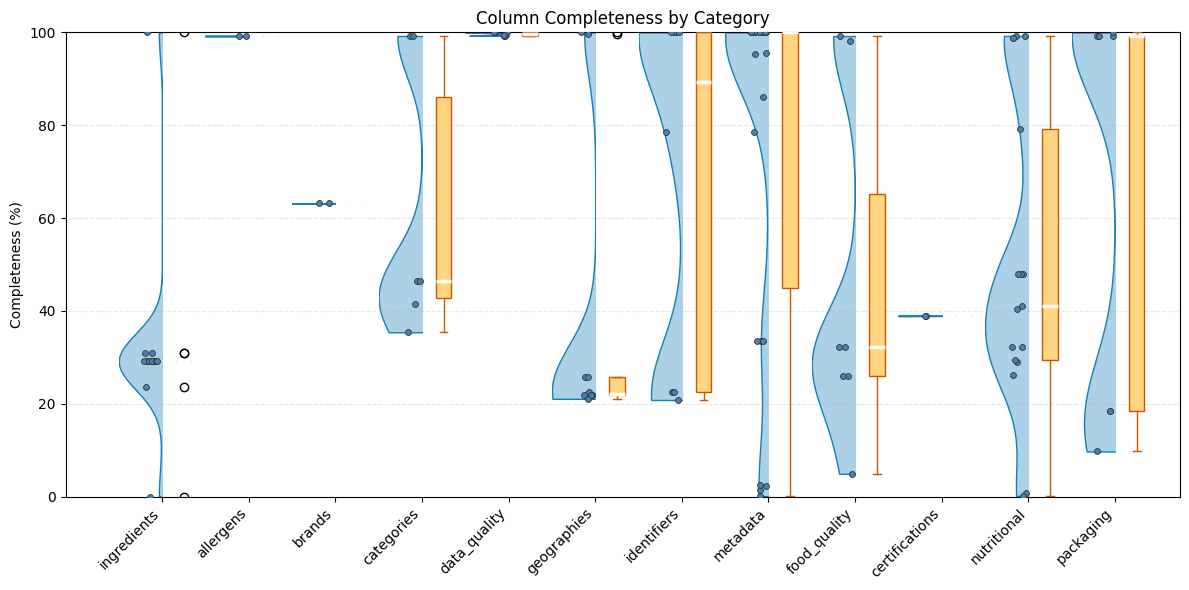

In [17]:
def plot_distribution_of_column_completeness_by_category():
    completeness = 100 - column_analysis_df["missing_percentage"]

    fig, ax = plt.subplots(figsize=(12, 6))
    plot_half_violin_with_box(
        values=completeness,
        groups=column_analysis_df["category"],
        ax=ax,
        value_limits=(0, 100),
        violin_width=1,
        box_width=0.18,
        box_offset=0.25,                 # set to 0.25 if you want it nudged horizontally
        transparent_side="right",       # make "left" if you prefer right solid
        violin_alpha_transparent = 0,
        title="Column Completeness by Category",
        ylabel="Completeness (%)",
        swarm_edge = "#333333",
        swarm_face = "steelblue",
        violin_face = "#A3CBE3",
        violin_edge = "#0173B2",
        box_face = "#FFD580",
        box_edge = "#CC5500",
    )
    plt.tight_layout()
    plt.show()

plot_distribution_of_column_completeness_by_category()

Analyse column completeness by category.

In [18]:
for category, group in column_analysis_df.groupby("category"):
    group = group.sort_values(by="missing_percentage", ascending=True)
    print(f"\nCategory: \033[94m{category}\033[0m\n")
    for i, row in enumerate(group.itertuples(index=False), start=1):
        print_col(i, row.column_name, desc=f"{100 - row.missing_percentage:6.2f} % completeness", sample=row.sample)


Category: allergens

  1. allergens_tags                           |  99.21 % completeness | ['en:nuts']
  2. traces_tags                              |  99.21 % completeness | []

Category: brands

  1. brands_tags                              |  63.18 % completeness | ['xx:bovetti']
  2. brands                                   |  63.16 % completeness | Bovetti

Category: categories

  1. categories_properties                    |  99.21 % completeness | {'ciqual_food_code': 31032, 'agribalyse_food_code': 31032, 'agribalyse_proxy_foo...
  2. food_groups_tags                         |  99.21 % completeness | ['en:sugary-snacks', 'en:sweets']
  3. categories_tags                          |  46.54 % completeness | ['en:breakfasts', 'en:spreads', 'en:sweet-spreads', 'fr:pates-a-tartiner', 'en:h...
  4. categories                               |  46.44 % completeness | Petit-déjeuners,Produits à tartiner,Produits à tartiner sucrés,Pâtes à tartiner,...
  5. compared_to_category           

## 6. Saving Analysis File

In [19]:
output_dir = 'data'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, 'column_analysis.csv')
column_analysis_df.to_csv(output_path, index=False)
print(f'Saved to {output_path}')

Saved to data/column_analysis.csv
